In [282]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
from pmdarima import auto_arima, model_selection, ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [283]:
%run datatools.py

# Read endogenous and exogenous data and filter country/dates

In [284]:
# We filter the country, the variable to predict and the dates

country = 'Sweden'
variable = 'new_deaths_'
col = variable + country
datecol = 'date'
initialdate = '2020-01-01'   # first day of the year, where our data starts
#enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

In [285]:
# We read the endogenous data (coronavirus data) (for now, from a local file) and extract last date of

covid_ctry_varR = pd.read_csv('./data/endogenous.csv', parse_dates=[datecol], index_col=[datecol], usecols=[datecol, col])
enddate = str(date.fromordinal(covid_ctry_varR.tail(1).index[0].toordinal())) # last day of available data

In [342]:
text = 'Test MAE: {}'.format(enddate)
text.rjust(70)

'                                                  Test MAE: 2020-09-20'

In [286]:
# We now read the exogenous data (for now, from a local file):

exogenous = pd.read_csv('./data/exogenous.csv', parse_dates=[datecol], index_col=[datecol])

# We now need to filter the country:
exogenous_ctryR = exogenous.loc[:, exogenous.columns.str.contains(country)]

In [287]:
# We check that effectively endogenous and exogenous data have the same length:
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(264, 1) (264, 14)


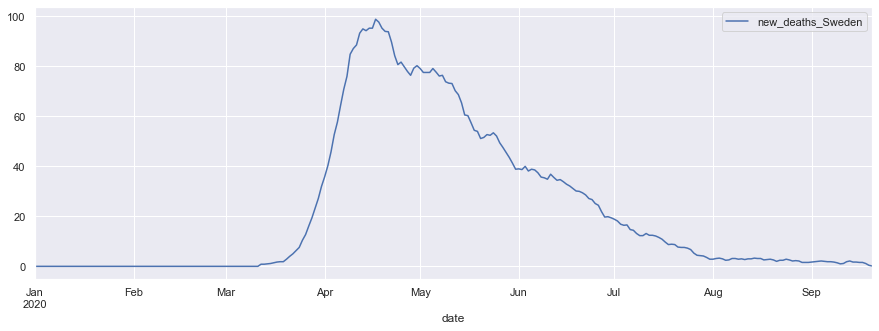

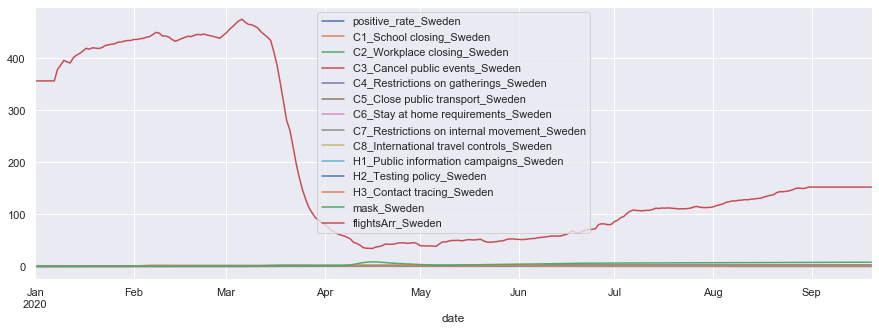

In [288]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [289]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [290]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
y = scaled_output.resample('1D').sum()

(264,) (264, 14)


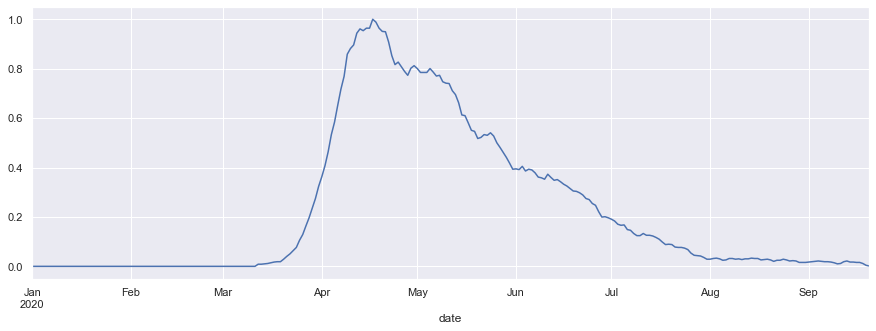

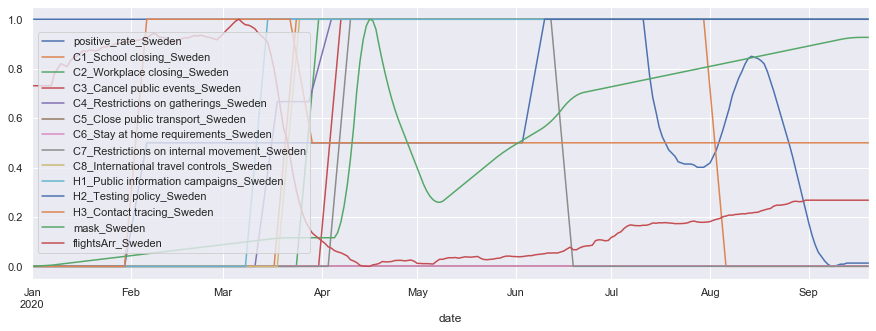

In [291]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [292]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [293]:
train_size, test_size

(224, 40)

# Stationarity: estimate differencing term (d)

In [294]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  1
KPSS test:  2
PP test:  1


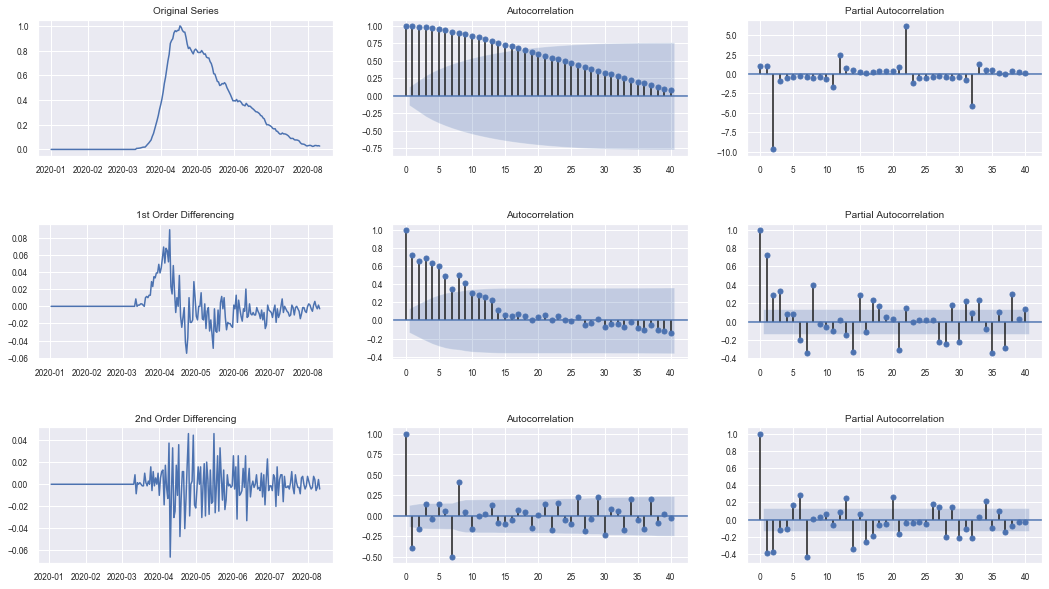

In [295]:
# Plotting ACF and PACF for different 'd' values (d=1, d=2):

plot_acf_pacf(y_train)
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

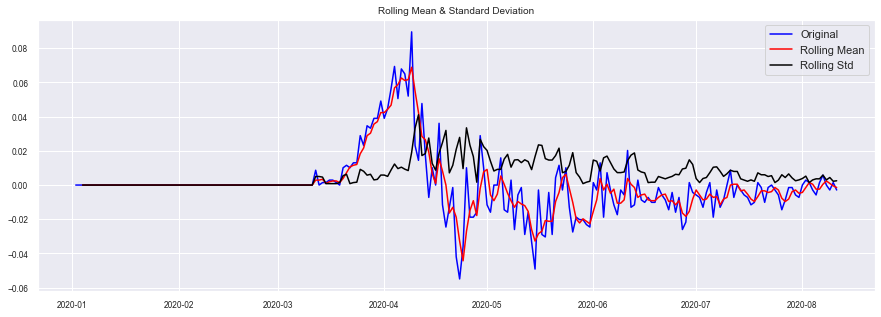

Result of Dicky-Fuller Test


Test Statistic           -3.124389
p-value                   0.024800
#Lags Used               15.000000
#Observations Used      207.000000
Critical Value (1%)      -3.462342
Critical Value (5%)      -2.875606
Critical Value (10%)     -2.574267
dtype: float64

In [296]:
# Test stationarity and print results of ADF test:
test_stationarity(y_train.diff().dropna())

# Estimate orders p and q of ARIMA model, using auto_arima

In [297]:
# Perform different auto_arima searches and sort results by lowest AIC:
result_table = autoarimas(y_train, X_train)
result_table

,parameters,aic
0,"(0, 1, 4)",-1359.759228
1,"(1, 1, 0)",-1340.738178
2,"(0, 2, 5)",-1340.246036
3,"(2, 2, 1)",-1325.846610


# Perform cross-validation on top 3 models and select the best. Then train and fit SARIMAX model with the one that gave best results

In [298]:
# Extract top 3 models from previous step (first 3 elements, since they are sorted):
model1 = ARIMA(order=result_table.iloc[0,0])
model2 = ARIMA(order=result_table.iloc[1,0])
model3 = ARIMA(order=result_table.iloc[2,0])

In [299]:
best_order = cross_val(y_train, X_train, model1, model2, model3)

Model 1 CV scores: ['0.2708', '0.0582', '0.0300', '0.1427', '0.0597', '0.0177', '0.1315', '0.0530', '0.0251', '0.0058', '0.0257']
Model 2 CV scores: ['0.2804', '0.0631', '0.0295', '0.1478', '0.0582', '0.0190', '0.1385', '0.0333', '0.0097', '0.0252', '0.0302']
Model 3 CV scores: ['0.3430', '0.1433', '0.0438', '0.0332', '0.0243', '0.0994', '0.0959', '0.0911', '0.0751', '0.0852', '0.0416']
Lowest average MAE: 0.07457566512338915 (model1)
Best model order: (0, 1, 4)


                               SARIMAX Results                                
Dep. Variable:      new_deaths_Sweden   No. Observations:                  224
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 702.671
Date:                Mon, 21 Sep 2020   AIC                          -1367.343
Time:                        23:17:49   BIC                          -1302.607
Sample:                    01-01-2020   HQIC                         -1341.209
                         - 08-11-2020                                         
Covariance Type:                  opg                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
positive_rate_Sweden                           -0.0344      0.065     -0.530      0.596      -0.162       0.093
C1_School closing_Sweden        

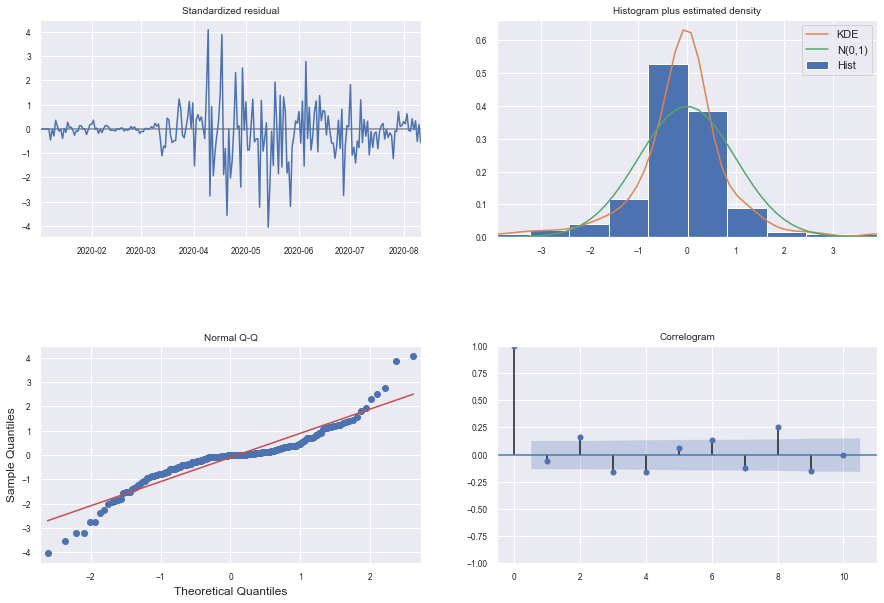

In [300]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=best_order, exog=X_train)
results = best_model.fit(full_output=False, disp=False)
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model MAE

In [301]:
train_size, test_size, X_test.shape

(224, 40, (40, 14))

Test MAE (0-1 scale): 0.029


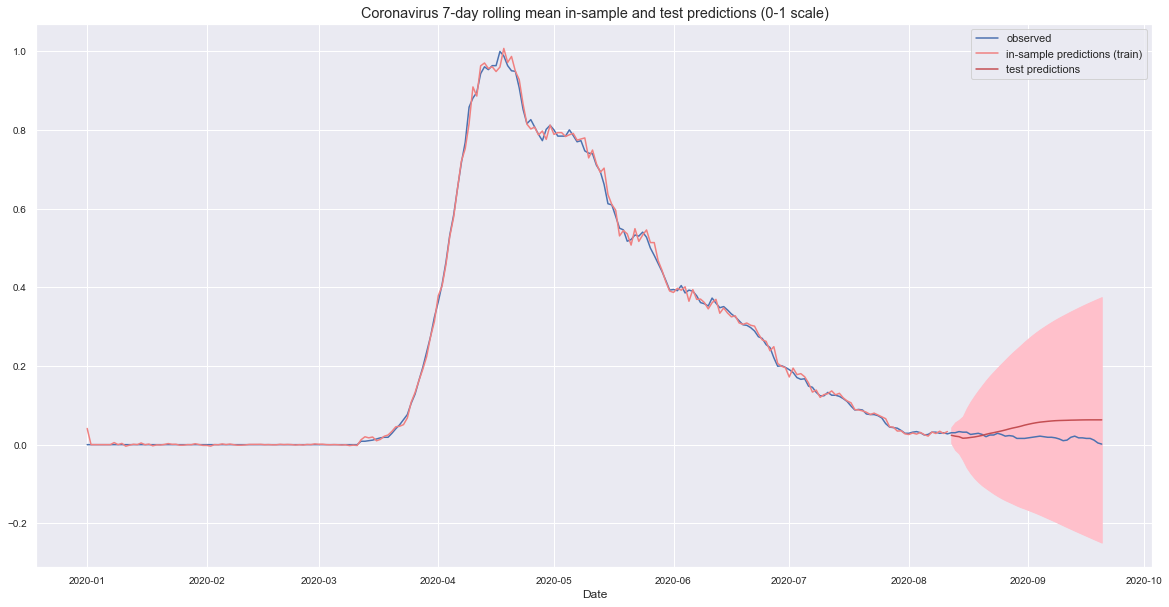

In [302]:
in_predictions, mean_forecast = in_out_fcast_plot(results, test_size, y, y_test, X_train, X_test)

# set title and show plot
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.show()

# Scale data back to original values and plot

In [303]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.columns[0])

In [304]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.columns[0])
testPredictS = testPredictS.clip(lower=0)

In [305]:
mae_orig = mean_absolute_error(covid_ctry_varR[train_size:], testPredictS)
mae_orig_perc = mae_orig / covid_ctry_varR[train_size:].mean()[0]
print("Test MAE (original scale): {:.1f}".format(mae_orig))

Test MAE (original scale): 2.9


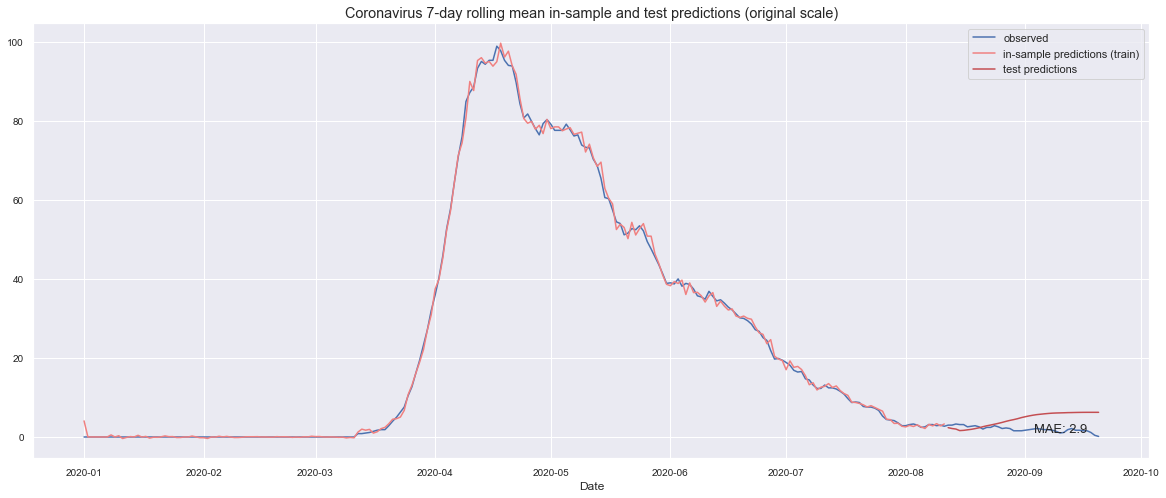

In [306]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.text(0.82, 0.17, 'MAE: {:.1f}'.format(mae_orig), transform = plt.gcf().transFigure, fontsize=13)
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

# Save model so we can then update with future values

In [307]:
# Set model name
filename = './models/' + country.replace(" ", "") + '_' + variable + 'model.pkl'

# Pickle it
joblib.dump(results, filename)

['./models/Sweden_new_deaths_model.pkl']

In [308]:
# Load the model back in
loaded_model = joblib.load(filename)

In [309]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      new_deaths_Sweden   No. Observations:                  224
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 702.671
Date:                Mon, 21 Sep 2020   AIC                          -1367.343
Time:                        23:17:50   BIC                          -1302.607
Sample:                    01-01-2020   HQIC                         -1341.209
                         - 08-11-2020                                         
Covariance Type:                  opg                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
positive_rate_Sweden                           -0.0344      0.065     -0.530      0.596      -0.162       0.093
C1_School closing_Sweden                        0.0466      0.118      0.397      0.692      -0.184       0.277
C2_Workplace closing_Sweden                     0.2216      0.134      1.658      0.097      -0.040       0.484
C3_Cancel public events_Sweden                  0.2393      0.043      5.509      0.000       0.154       0.324
C4_Restrictions on gatherings_Sweden            0.1486      0.084      1.763      0.078      -0.017       0.314
C5_Close public transport_Sweden             1.567e-16   9.62e-17      1.629      0.103   -3.19e-17    3.45e-16
C6_Stay at home requirements_Sweden         -5.142e-17        nan        nan        nan         nan         nan
C7_Restrictions on internal movement_Sweden     0.1581      0.041      3.866      0.000       0.078       0.238
C8_International travel controls_Sweden         0.0929      0.104      0.889      0.374      -0.112       0.298
H1_Public information campaigns_Sweden         -0.0161      0.169     -0.096      0.924      -0.347       0.315
H2_Testing policy_Sweden                       -0.2303      0.065     -3.539      0.000      -0.358      -0.103
H3_Contact tracing_Sweden                       0.0988      0.091      1.082      0.279      -0.080       0.278
mask_Sweden                                     0.1625      0.034      4.816      0.000       0.096       0.229
flightsArr_Sweden                               0.1034      0.104      0.998      0.318      -0.100       0.307
ma.L1                                           0.4283      0.038     11.164      0.000       0.353       0.503
ma.L2                                          -0.1932      0.035     -5.491      0.000      -0.262      -0.124
ma.L3                                           0.5124      0.037     13.664      0.000       0.439       0.586
ma.L4                                           0.8054      0.033     24.171      0.000       0.740       0.871
sigma2                                          0.0001   6.11e-06     17.144      0.000    9.27e-05       0.000
===================================================================================
Ljung-Box (Q):                      113.33   Jarque-Bera (JB):               173.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.64   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.28e+17. Standard errors may be unstable.
"""

# Update model with test observations, to get it ready for future forecasts

In [323]:
# Update model with test sample and re-fit parameters:
#res_updated = results.append(y_test, exog=X_test, refit=True, full_output=False, disp=False)

In [326]:
# Update model with test sample:
res_updated = results.append(y_test, exog=X_test)

                               SARIMAX Results                                
Dep. Variable:      new_deaths_Sweden   No. Observations:                  264
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 847.006
Date:                Mon, 21 Sep 2020   AIC                          -1656.011
Time:                        23:22:26   BIC                          -1588.140
Sample:                    01-01-2020   HQIC                         -1628.735
                         - 09-20-2020                                         
Covariance Type:                  opg                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
positive_rate_Sweden                           -0.0344      0.065     -0.530      0.596      -0.162       0.093
C1_School closing_Sweden        

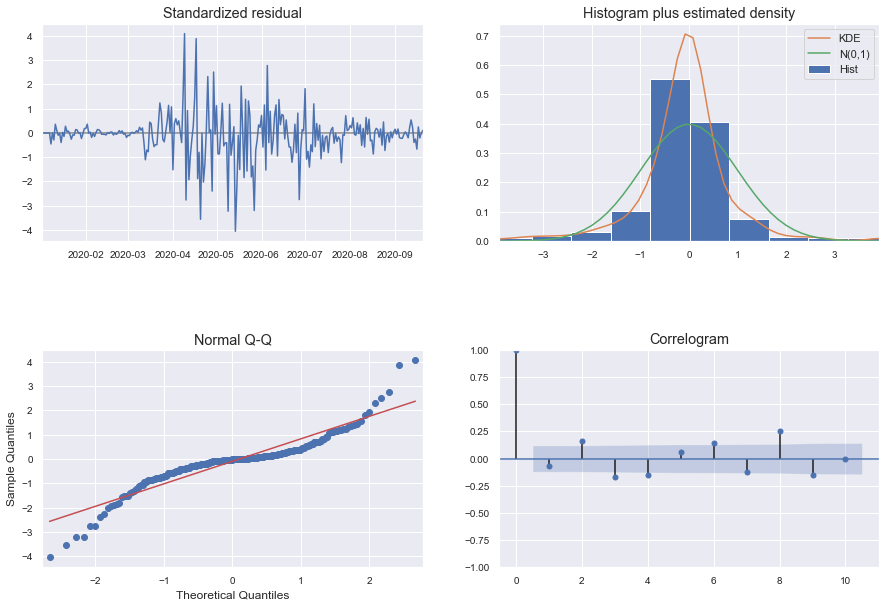

In [327]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

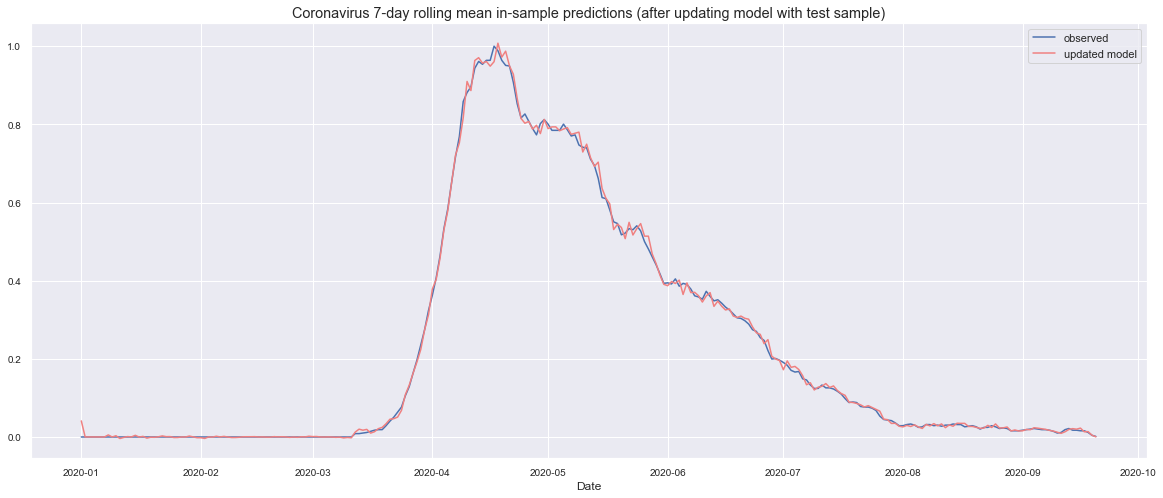

In [328]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [329]:
# Save model again, after updating it with test sample:

joblib.dump(res_updated, filename)

['./models/Sweden_new_deaths_model.pkl']

# Perform forecast

In [330]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdate, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

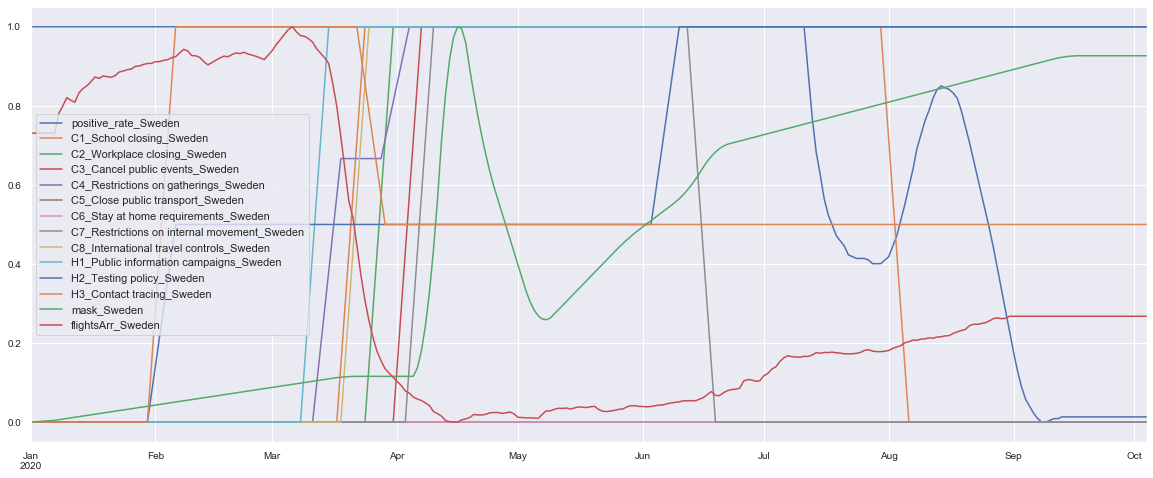

In [331]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.00283415 0.00080644 0.00116848 0.00199191 0.00199191 0.00199191
 0.00199191 0.00199191 0.00199191 0.00199191 0.00199191 0.00199191
 0.00199191 0.00199191]


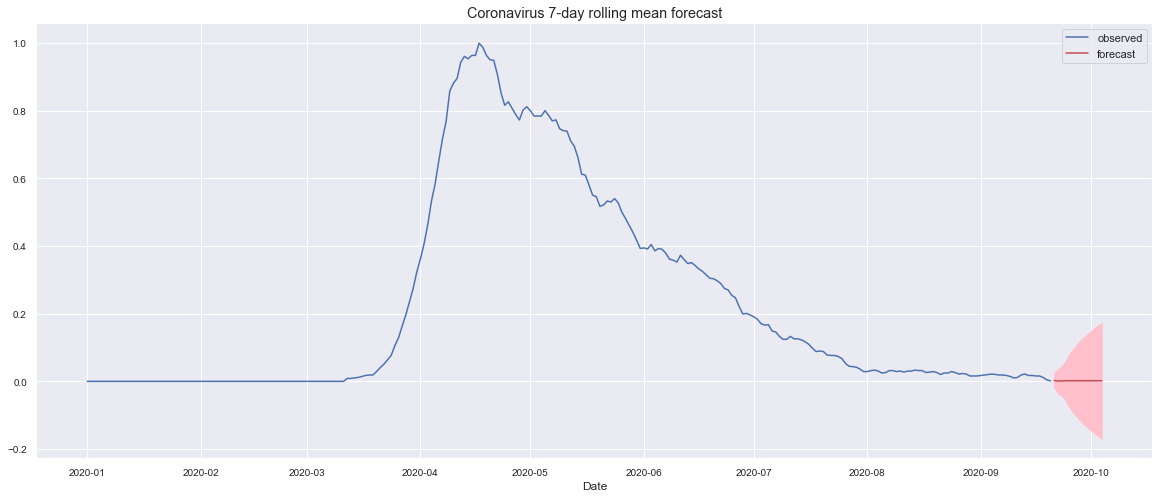

In [332]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean and assign negative values to zero (negative numbers don't make sense here):
mean_forecast = forecast.predicted_mean
mean_forecast = mean_forecast.clip(lower=0)

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + y.name]
upper_limits = confidence_intervals.loc[:,'upper ' + y.name]

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [333]:
forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')
forecast14S = forecast14S.clip(lower=0)

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')

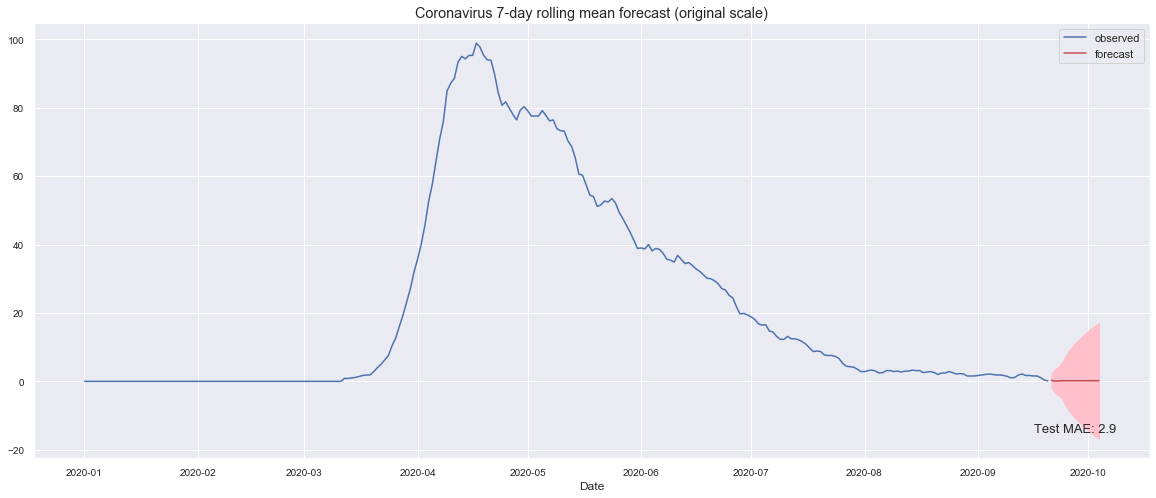

In [334]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(forecast14S.index, forecast14S, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(forecast14_llS.index, forecast14_llS, forecast14_ulS, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast (original scale)')
plt.text(0.82, 0.17, 'Test MAE: {:.1f}'.format(mae_orig), transform = plt.gcf().transFigure, fontsize=13)
plt.legend()
plt.show()

In [335]:
# Print forecasted values:

forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print(forecast14S_l)

['0.3', '0.1', '0.1', '0.2', '0.2', '0.2', '0.2', '0.2', '0.2', '0.2', '0.2', '0.2', '0.2', '0.2']


In [336]:
sm.__version__

'0.11.1'

In [337]:
import pmdarima as pm
pm.__version__

'1.6.1'